In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
import confseq
from confseq.conjmix_bounded import *

In [3]:
import multiprocess as mp

# Data generation

Generate some Bernoulli data since we're going to be using sub-Bernoulli CSes.

In [4]:
def generate_bernoulli(ps):
    data = scipy.stats.bernoulli.rvs(ps)
    return data

def make_z_wave(lag, p_vals, n):
    idx_arr = np.arange(n)
    ps = np.zeros(n).astype(float)
    for idx, p in enumerate(p_vals):
        ps[np.mod(idx_arr // lag, len(p_vals)) == idx] = p
    return ps

def make_sine_wave(period, low, high, n):
    return (np.sin(2 * np.pi / period * np.arange(n)) / 2 + 0.5) * (high - low) + low

In [5]:
n = 5000
p_map = {
    'Stationary': np.full((n,), 0.5), 
    'Changepoint': make_z_wave(500, [0.4, 0.9], n), 
    'Z Wave': make_z_wave(int(np.ceil(0.8 * n)), [0.1, 0.9], n),
    '0-1 Wave': make_z_wave(int(np.ceil(.4 * n)), [0., 1.], n),
    'Sine Wave': make_sine_wave(400, 0.1, 0.9, n)
}
datasets = {k: generate_bernoulli(v) for k, v in p_map.items()}

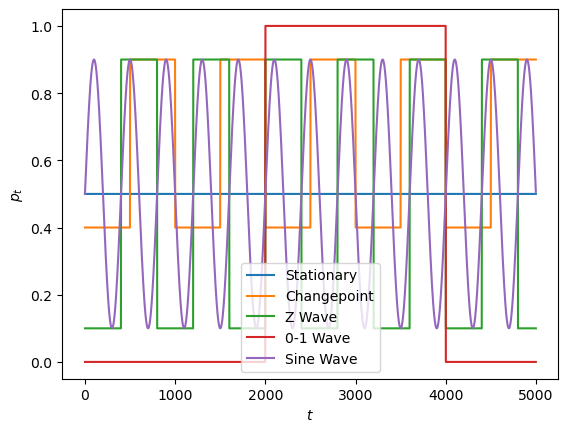

In [6]:
fig, ax = plt.figure(), plt.gca()
for data_name, ps in p_map.items():
    ax.plot(np.arange(ps.shape[0]), ps, label=data_name)
ax.set_xlabel('$t$')
ax.set_ylabel('$p_t$')
ax.legend()

Only need to create suffix CSes at the time steps we visualize (otherwise takes too long to compute everything)

In [7]:
visual_steps = np.arange(0, 1000, 100)
print(visual_steps)

[  0 100 200 300 400 500 600 700 800 900]


## Plotting functions

In [8]:
from tqdm.notebook import tqdm

linestyle_map = dict([
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dashed', 'dashed'),    # Same as '--'

        ('dashdot', 'dashdot'),  # Same as '-.'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
    #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
])

def plot_cs_list(cs_list, start_idx=1, end_idx=1000, incr=100, single_cs=None, visual_steps=None):
    fig, ax = plt.figure(), plt.gca()
    steps = range(start_idx, end_idx, incr) if visual_steps is None else range(len(cs_list))
    for i in steps:
        ax.plot(np.arange(visual_steps[i] + 1, cs_list[i].shape[0] + visual_steps[i] + 1), cs_list[i], \
                label=f"$s={i if visual_steps is None else visual_steps[i]}$")
    if single_cs is not None:
        ax.plot(np.arange(1, cs_list[0].shape[0]+1), single_cs, label='single cs')
    ax.legend()
    return fig, ax

def plot_multiple_cs_list(cs_list_map, start_idx=1, end_idx=1000, incr=100, single_cs=None, p=None, visual_steps=None, \
                          linestyles=['solid', 'dashed', 'dotted']):
    fig, ax = plt.figure(), plt.gca()
    cmap = matplotlib.cm.get_cmap('tab10')
    for idx, (name, cs_list) in enumerate(cs_list_map.items()):
        linestyle = linestyles[idx]
        
        steps = range(start_idx, end_idx, incr) if visual_steps is None else range(len(visual_steps))
        for step_idx, i in enumerate(steps):
            color = cmap(step_idx)
            start = i if visual_steps is None else visual_steps[i]
            ax.plot(np.arange(start + 1, start + cs_list[i].shape[0] + 1), cs_list[i], color=color, linestyle=linestyle, \
                    label=name if i == steps[0] else None)
    ax.legend()
    return fig, ax


def plot_multiple_cs_list_t(cs_list_map, t, linestyles=['solid', 'dashed', 'dotted'], ax=None, style='single'):
    if ax is None:
        fig, ax = plt.figure(), plt.gca()
    else:
        fig = plt.gcf()
    cmap = matplotlib.cm.get_cmap('tab10')
    for idx, (name, cs_list) in enumerate(cs_list_map.items()):
        linestyle = linestyles[idx]
        color = cmap(idx)
        if style == 'single':
            s_intervals = [cs_list[s][t - s - 1] for s in range(t)]
            ax.plot(np.arange(t), s_intervals, color=color, linestyle=linestyle, label=name)
        else:
            l_s_intervals, u_s_intervals = [cs_list[s][0][t - s - 1] for s in range(t)], \
                                            [cs_list[s][1][t - s - 1] for s in range(t)]
            ax.plot(np.arange(t), l_s_intervals, color=color, linestyle=linestyle, label=name)
            ax.plot(np.arange(t), u_s_intervals, color=color, linestyle=linestyle)
    return fig, ax

def get_width(cs_suffix_list):
    a, b = cs_suffix_list[0]
    return [b - a for a, b in cs_suffix_list]

# Union Bound over Empirical Bernstein CSes.

In [9]:
alpha = 0.05
empbern_lb_cses = [conjmix_empbern_lower_cs(datasets['Stationary'][i:], 1, alpha=alpha / ((i + 1) * (i + 2))) for i in visual_steps]
print([len(x) for x in empbern_lb_cses])

[5000, 4900, 4800, 4700, 4600, 4500, 4400, 4300, 4200, 4100]


In [10]:
single_cs = conjmix_empbern_lower_cs(datasets['Stationary'], n // 2, alpha=alpha)

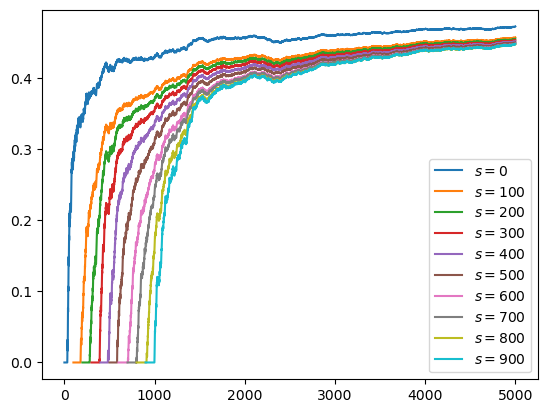

In [11]:
fig, ax = plot_cs_list(empbern_lb_cses, visual_steps=visual_steps)

## Variance adaptive suffix CS

In [12]:
def alpha_i(alpha, i):
    return alpha / ((i + 1) * (i + 2))

def first_save_idx(alpha, i):
    idx = np.sqrt(2 / alpha) * (i + 1) * (i + 2)
    threshold = 2 * np.square(i + 1) * np.square(i + 2) / alpha
    if np.floor(idx) * (np.floor(idx) + 1) >= threshold:
        return int(np.floor(idx)) - 1
    else:
        return int(np.ceil(idx)) - 1
    
def linear_lambda(alpha, v_opt):
    return np.minimum(np.sqrt(2 * np.log(1 / alpha) / (v_opt)), 0.5)
    

def eb_psi(lam):
    """Requires lam \in [0, 1)"""
    return -1 * np.log(1 - lam) - lam

def interp_mean_cs(cs, offset):
    lcs, ucs = cs
    if offset == 0:
        return cs
    else:
        t = ucs.shape[0]
        sum_lcs, sum_ucs = np.arange(1, t + 1) * lcs, np.arange(1, t + 1) * ucs
        s_sum_lcs, s_sum_ucs = sum_lcs[offset:] - sum_ucs[offset - 1], sum_ucs[offset:] - sum_lcs[offset - 1]
    return s_sum_lcs / np.arange(1, t - offset + 1), s_sum_ucs / np.arange(1, t - offset + 1)

def var_adapt_twosided_empbern(
    xs, 
    alpha, 
    D=5, 
    predictor='running_mean', 
    bdry_type='conj_mix', 
    restart_type='fixed',
    v_opt=1, 
    debug=False,
    max_var=1,
    thresh_scale=0.5):
    
    t = xs.shape[0]
    ts = np.arange(1, t + 1)
    S_t = np.cumsum(xs)
    mu_hat_t = S_t / ts
    
    def make_V_st(s):
        if predictor == 'running_mean':
            X_hat_st = np.append(0.5, (np.cumsum(xs[s:]) / np.arange(1, t - s + 1))[:-1])
            V_st = np.cumsum(np.square(xs[s:] - X_hat_st))
        elif predictor == 'adagrad':
            cum_mean = np.cumsum(xs[s:]) / np.arange(1, t - s + 1)
            best_loss = np.cumsum(np.square(xs[s:] - cum_mean))
            regret = 16 + (4 * np.sqrt(2)) * np.sqrt(8 + best_loss) 
            V_st = best_loss + regret
        else:
            assert False
        return np.minimum(V_st, np.arange(1, V_st.shape[0] + 1) * max_var)
    
    def make_boundary(V_t, alpha, lam=None):
        if bdry_type == 'conj_mix':
            boundary = confseq.boundaries.gamma_exponential_mixture_bound(
                V_t, alpha=alpha, v_opt=v_opt, c=1, alpha_opt=alpha
            )
        else:
            assert lam is not None
            boundary = (np.log(1 / alpha) + eb_psi(lam) * V_t) / lam
        return boundary / np.arange(1, boundary.shape[0] + 1)
    
    all_V_st = [make_V_st(s) for s in range(t)]
    lam_const = linear_lambda(alpha / 2, v_opt)
                
    tau = [0]
    backcheck_idxs = {first_save_idx(alpha, 0): 0}
    cur_save_idx, save_tau = None, None
    build_pairs = [(0, 0)]
    for i in range(t - 1):
        if restart_type == 'fixed':
            if all_V_st[tau[-1]][i - tau[-1]] >= D:
                build_pairs.append((len(tau), i + 1))
                tau.append(i + 1)
        else:
            # check if next tau could be covered by an existing level
            if len(tau) in backcheck_idxs:
                cur_save_idx = backcheck_idxs[len(tau)]
                cur_save_tau = tau[cur_save_idx]
            if cur_save_idx is not None:
                accrued_v = all_V_st[cur_save_tau][i - cur_save_tau]
                save_alpha = alpha_i(alpha, cur_save_idx)
                next_alpha = alpha_i(alpha, len(tau))
                if restart_type == 'conj_mix':
                    
                    save_widths = np.array([confseq.boundaries.gamma_exponential_mixture_bound(2 * all_V_st[j][i - j],
                                                                                 alpha=np.square(alpha_i(alpha, rho) / 2), 
                                                                                 v_opt=v_opt, 
                                                                                 c=1, 
                                                                                 alpha_opt=alpha_i(alpha, rho) / 2) \
                                   for rho, j in enumerate(tau)])
                    
                    # print('Next alpha boundary:', np.log(2 / next_alpha), 'min save_width:', np.min(save_widths))
                    test_mask = np.log(2 / next_alpha) >= save_widths / thresh_scale
                    if np.any(test_mask):
                        save_idx = np.max(np.where(test_mask))
                        build_pairs.append((save_idx, tau[save_idx]))
                    else:
                        build_pairs.append((len(tau), i + 1))
                        tau.append(i + 1)
                        backcheck_idxs[first_save_idx(alpha, i + 1)] = i + 1
                        
                else:
                    assert restart_type == 'linear'
                    next_alpha = alpha_i(alpha, len(tau))
                    next_lam = linear_lambda(next_alpha / 2, v_opt)
                    # next_lam = lam_const
                    
                    stopped = False
                    for rho, tau_val in enumerate(tau):
                        save_alpha = alpha_i(alpha, rho)
                        save_lam = linear_lambda(save_alpha / 2, v_opt)
                        # save_lam = lam_const
                        # print(save_lam, next_lam)
                        threshold = (save_lam * np.log(2 / next_alpha) - (next_lam * 2 * np.log(2 / save_alpha))) \
                                     / (2 * eb_psi(save_lam) * next_lam)
                        # if threshold >= 0:
                        #    print(all_V_st[tau_val][i - tau_val], threshold)
                        if all_V_st[tau_val][i - tau_val] <= threshold:
                            build_pairs.append((rho, tau_val))
                            print("Trigger", rho, tau_val, i)
                            stopped = True
                            break
                    if not stopped:
                    # threshold = np.log(np.square(save_alpha) / (2 * next_alpha)) / (2 * eb_psi(lam_const)) * thresh_scale 
                        build_pairs.append((len(tau), i + 1))
                        tau.append(i + 1)
                        backcheck_idxs[first_save_idx(alpha, i + 1)] = i + 1
                    # print(accrued_v, threshold, cur_save_idx, cur_save_tau, i)
                    """
                    if accrued_v >= threshold: 
                        # condition where union bound beats bounds arithmetic (assume alpha series is decreasing)
                        build_pairs.append((len(tau), i + 1))
                        tau.append(i + 1)
                        backcheck_idxs[first_save_idx(alpha, i + 1)] = i + 1
                    else:
                        build_pairs.append((cur_save_idx, cur_save_tau))
                    """
            else:
                build_pairs.append((len(tau), i + 1))
                tau.append(i + 1)
                backcheck_idxs[first_save_idx(alpha, i + 1)] = i + 1
            
    assert len(build_pairs) == t, build_pairs
    cses = []
    for s, (rho, tau) in enumerate(build_pairs):
        var_penalty = 2 * all_V_st[tau][s - tau] if s > tau else 0 # Penalty of 2 * V_{rho(s), s - 1}
        total_var = all_V_st[s] + var_penalty
        
        cur_alpha = np.square(alpha_i(alpha, rho)) / 2 if s > tau else alpha_i(alpha, rho)
        lam = linear_lambda(alpha_i(alpha, rho) / 2, v_opt) # always choosing the union bound lambda...
        # print(lam)
        # print(lam)
        # lam = lam_const
        boundary = make_boundary(total_var, cur_alpha / 2, lam=lam)
        
        mu_hat_st = np.cumsum(xs[s:]) / np.arange(1, t - s + 1)
        cses.append((mu_hat_st - boundary, mu_hat_st + boundary))
    
    debug_map = {
        'tau': tau,
        'all_V_st': all_V_st
    }
    if debug:
        return [np.clip(cs, 0, 1) for cs in cses], debug_map
    else:
        return [np.clip(cs, 0, 1) for cs in cses]


### Experiments

In [13]:
names = []
fns = []

In [14]:
# datasets = {'0-1 Wave': datasets['0-1 Wave']}

In [15]:
# result_map = {}
v_opt = 100
for data_name, data in tqdm([(k, v) for k, v in datasets.items()], disable=True):
    names.append((data_name, f'Var. Adapt (Linear Re+Bdry)'))
    def var_adapt_lr_fn(data_name):
        return var_adapt_twosided_empbern(datasets[data_name], alpha, D=None, v_opt=v_opt, \
                                         bdry_type='linear', restart_type='linear', predictor='adagrad', thresh_scale=1.)
    fns.append((var_adapt_lr_fn, data_name))
    """
    names.append((data_name, f'Var. Adapt (Conj. Mix Re+Bdry)'))
    def var_adapt_lr_fn(data_name):
        return var_adapt_twosided_empbern(datasets[data_name], alpha, D=None, v_opt=v_opt, \
                                         bdry_type='conj_mix', restart_type='conj_mix', predictor='adagrad', thresh_scale=1.)
    fns.append((var_adapt_lr_fn, data_name))
    """
    
    names.append((data_name, 'Union Bound (Linear Bdry)'))
    def ub_fn(data_name):
        return var_adapt_twosided_empbern(datasets[data_name], alpha, D=0, v_opt=v_opt, \
                                          bdry_type='linear', predictor='adagrad')
    fns.append((ub_fn, data_name))
    
    """
    names.append((data_name, 'Union Bound (Conj. Mix. Bdry)'))
    def ub_fn(data_name):
        return var_adapt_twosided_empbern(datasets[data_name], alpha, D=0, v_opt=v_opt, \
                                          bdry_type='conj_mix', predictor='adagrad')
    fns.append((ub_fn, data_name))
    """
with mp.Pool(1) as p:
    results =  list(tqdm(p.imap(lambda x: x[0](x[1]), fns), leave=False, desc='running jobs', total=len(fns)))
    result_map = dict(zip(names, results))

running jobs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

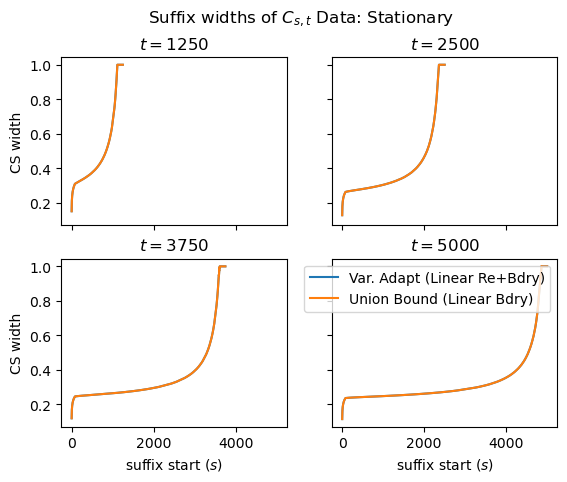

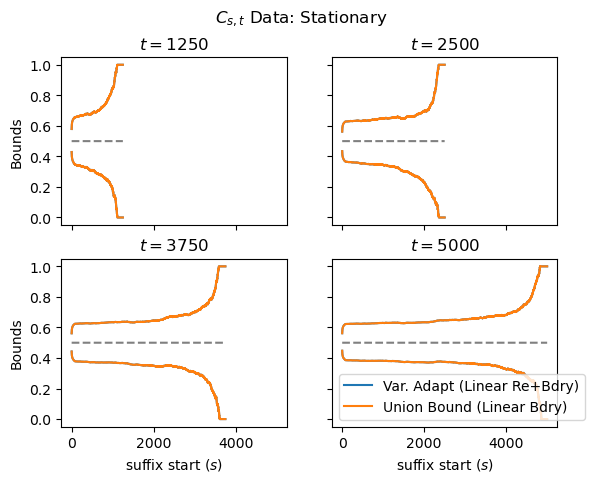

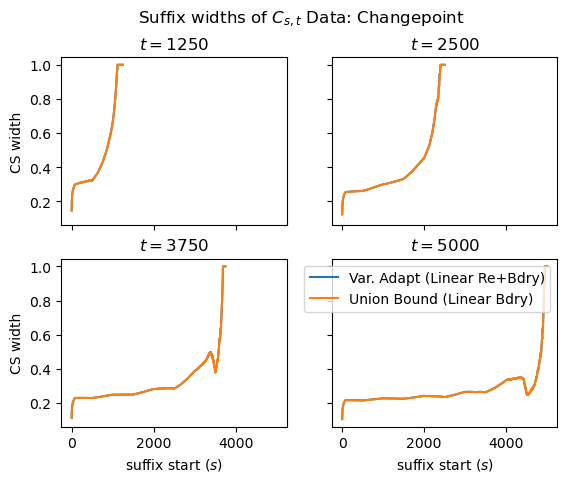

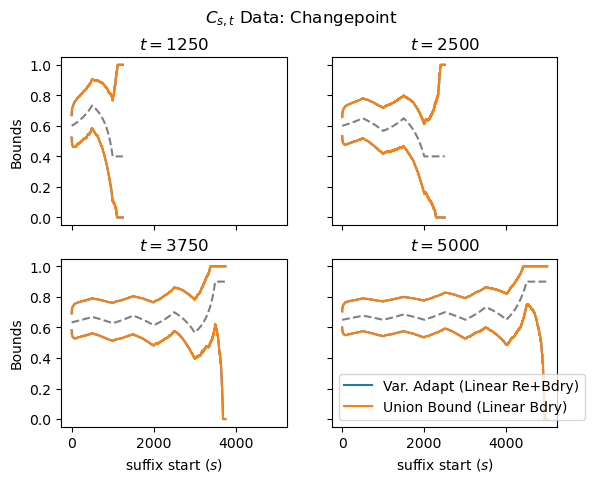

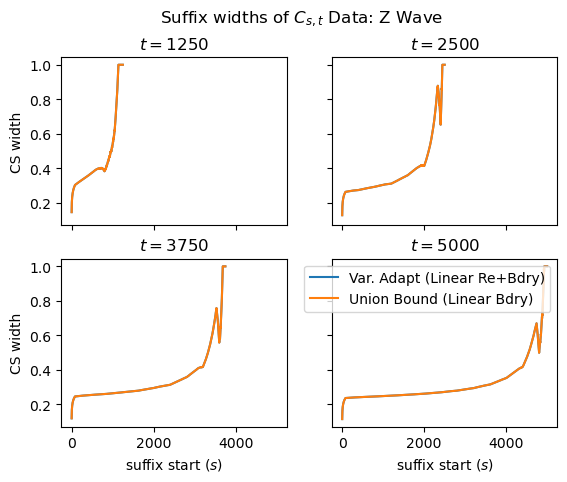

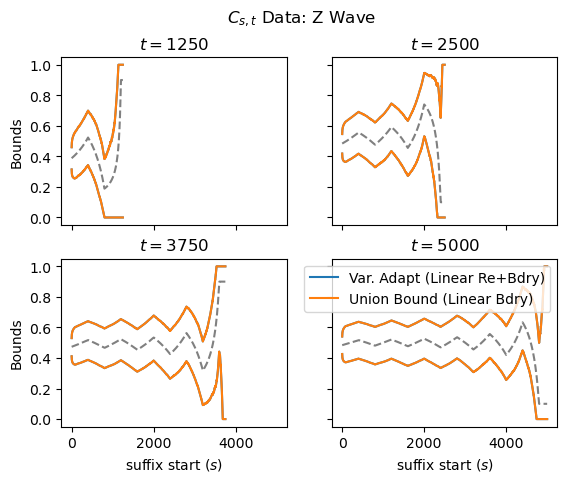

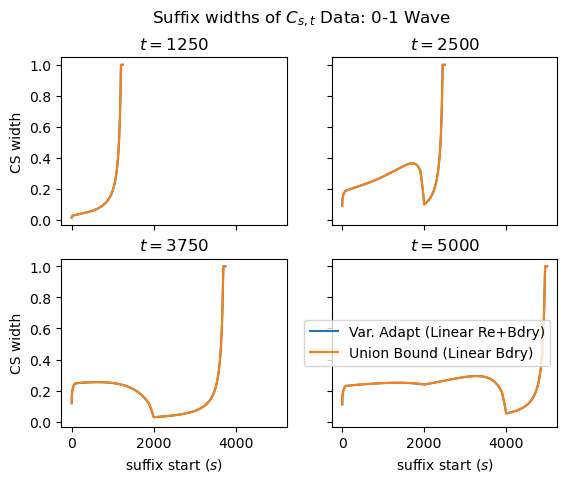

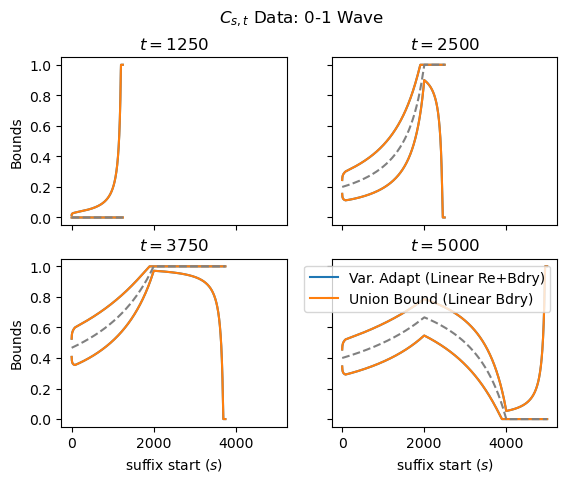

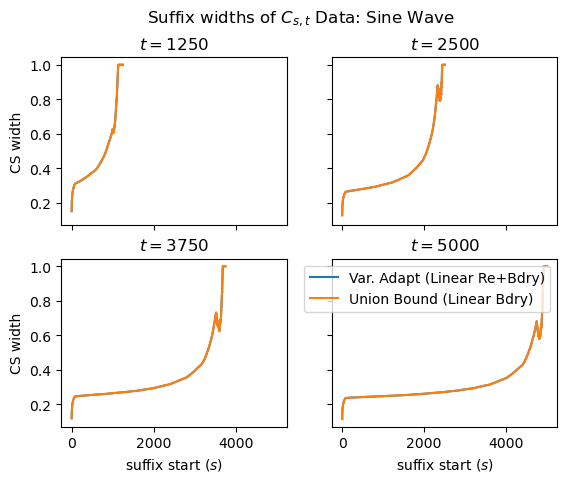

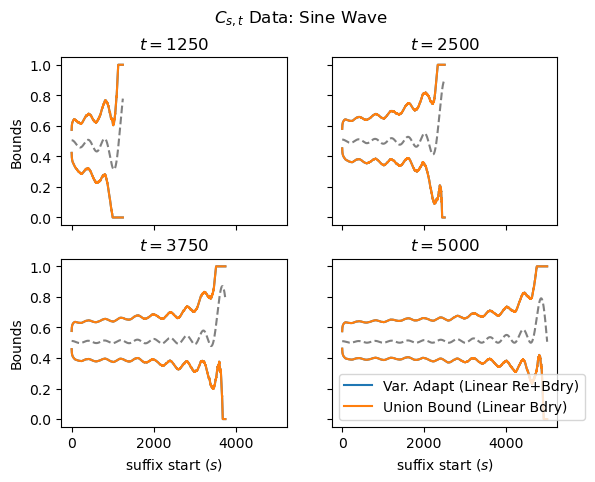

In [16]:
for data_name, data in tqdm(datasets.items()):    
    # Plot the widths
    method_names = ['Var. Adapt (Linear Re+Bdry)', 'Union Bound (Linear Bdry)', \
                    'Var. Adapt (Conj. Mix Re+Bdry)', 'Union Bound (Conj. Mix. Bdry)']
    width_data_result_map = {k[1]: get_width(v) for k, v in result_map.items() if k[0] == data_name and k[1] in method_names}
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=False)
    for t, ax in zip([int(np.ceil(x)) for x in np.linspace(n / 4, n, 4)], axes.flatten()):
        plot_multiple_cs_list_t(width_data_result_map, t=t, linestyles=['solid', 'solid'], ax=ax, style='single')
        ax.set_title(f'$t={t}$')
    for i in [0, 1]:
        axes[-1, i].set_xlabel('suffix start ($s$)')
        axes[i, 0].set_ylabel('CS width')
    
    ax.legend()
    fig.suptitle('Suffix widths of $C_{s, t}$' + f' Data: {data_name}')

    # Plot suffix intervals themselves
    interval_data_result_map = {k[1]: v for k, v in result_map.items() if k[0] == data_name and k[1] in method_names}
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, squeeze=False)
    for t, ax in zip([int(np.ceil(x)) for x in np.linspace(n / 4, n, 4)], axes.flatten()):
        plot_multiple_cs_list_t(interval_data_result_map, t=t, linestyles=['solid', 'solid'], ax=ax, \
                                style='double')
        # Plot true suffix means
        ps = p_map[data_name]
        avg_ps = np.cumsum(ps[:t][::-1])[::-1] / (t - np.arange(t))
        ax.plot(np.arange(t), avg_ps, color='gray', linestyle='dashed')
        ax.set_title(f'$t={t}$')

    for i in [0, 1]:
        axes[-1, i].set_xlabel('suffix start ($s$)')
        axes[i, 0].set_ylabel('Bounds')
    
    ax.legend()
    fig.suptitle('$C_{s, t}$' + f' Data: {data_name}')

# Union bound over Mixture Bernoulli CS

In [17]:
bern_cses = [conjmix_bernoulli_cs(data[i:], 1, alpha=alpha / ((i + 1) * (i + 2)), parallel=True) for i in visual_steps]

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

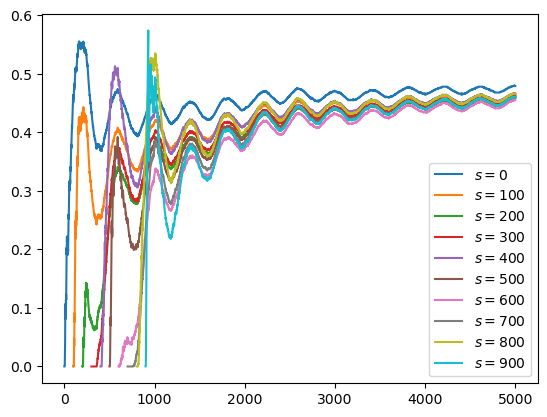

In [18]:
bern_lb_cses = [lb for lb, _ in bern_cses]
plot_cs_list(bern_lb_cses, visual_steps=visual_steps)

In [19]:
zeros_count = (1 - data).cumsum()
ones_count = data.cumsum()
save_bern_cses = [(conjmix_bernoulli_cs(data[i:], 1, alpha=alpha / ((zeros_count[i] + 1) * (zeros_count[i] + 2)), parallel=True)[0], \
                   conjmix_bernoulli_cs(data[i:], 1, alpha=alpha / ((ones_count[i] + 1) * (ones_count[i] + 2)), parallel=True)[1]) \
                   for i in visual_steps]
bern_cses = [conjmix_bernoulli_cs(data[i:], 1, alpha=alpha / ((i + 1) * (i + 2)), parallel=True) for i in visual_steps]
half_bern_cses = [conjmix_bernoulli_cs(data[i:], 1, alpha=alpha * 4 / ((i + 1) * (i + 2)), parallel=True) for i in visual_steps]

In [20]:
save_lb_bern_cses = [lb for lb, _ in save_bern_cses]

Here we plot the typical Bernoulli CS against the "Save Bern" CS which only alpha spends when a 0 is received --- this is because a 1 will increase all e-processes from the lower CS (and vice versa, i.e., 0 will increase all e-processes from the upper CS). We see that the "save Bern" CS is basically the same as the Bernoulli CS with quadruple $\alpha$, since each the index of the alpha spending is approximately half (and alpha spending is $1 / i(i + 1)$).

TypeError: 'Pool' object is not subscriptable

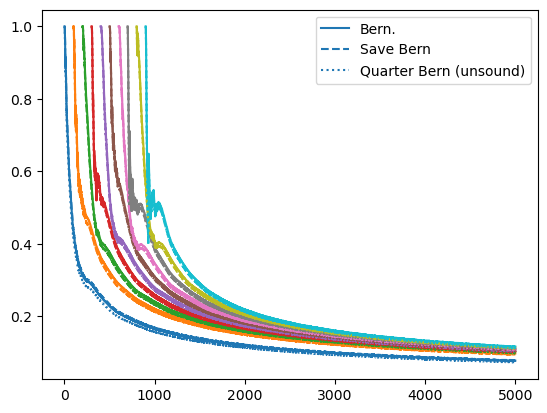

In [21]:
fig, ax = plot_multiple_cs_list({'Bern.': get_width(bern_cses), 'Save Bern': get_width(save_bern_cses), \
                                 'Quarter Bern (unsound)': get_width(half_bern_cses) }, visual_steps=visual_steps)

ax.set_title(f'Different Bern. $p$={p[0]}')

# Small bet Bernoulli CS for suffixes

Here the theory, is to note that the Bernoulli martingale can be written as follows:

$$E_t(\lambda) = \exp\left(\lambda t \left(\hat{\mu}_t -\mu_t\right) - \sum_{s \leq t} \log\left(h(\lambda, \theta_s)\right) \right) \geq \exp\left(\lambda t \left(\hat{\mu}_{t} -\mu_{t}\right) - t \log\left(h(\lambda, \mu_{t})\right) \right)$$
where
$$h(\lambda, z) := (1 - z) e^{-\lambda z} + z e^{\lambda (1 - z)}, $$ and the inequality is by concavity of $ \log h$.

In [ ]:
from confseq.betting import cs_from_martingale
from confseq.types import RealArray

def bern_log_fn(lambdas: RealArray, m: float):
    return np.log(((1 - m) * np.exp(-1 * lambdas * m)) + (m * np.exp(lambdas * (1 - m))))

def log_binomial_nsm(x: RealArray, m: float, lambdas: float):
    t = x.shape[0]
    return np.cumsum(lambdas * (x - m)) - np.cumsum(bern_log_fn(lambdas, m))

def binomial_cs(x: RealArray, lambdas: RealArray, alpha: float, log_dist_penalty: int, parallel: bool):
    def mart_fn(x: RealArray, m: float):
        return np.exp(log_binomial_nsm(x, m, lambdas) - log_dist_penalty) / 2 + \
            np.exp(log_binomial_nsm(1 - x, 1 - m, lambdas) - log_dist_penalty) / 2
    return cs_from_martingale(x, mart_fn, log_scale=True, alpha=alpha, parallel=parallel)



def prot_binomial_suffix_cs(x: RealArray, horizon_fn, alpha_fn, alpha, parallel: bool=False, visual_steps = None, bern_nsm='flat'):
    t = x.shape[0]
    horizons = horizon_fn(t)
    s_ranges = [0] + horizons[:-1] + [min(t, horizons[-1])]    
    suffix_cs_list = []
    for i in tqdm(range(len(s_ranges) - 1)):
        horizon = horizons[i]
        horizon_total_alpha = alpha_fn(alpha, i)
        k = int(np.ceil(np.sqrt(horizon * np.log(horizon + 1))))
        horizon_step_alpha = horizon_total_alpha / k
        horizon_lambda = np.sqrt(np.log(1 / horizon_step_alpha) / (horizon))
        
        block_len = int(np.ceil(horizon / k))
        start, end = (s_ranges[i], s_ranges[i + 1])
        
        for s in tqdm(range(start, end), leave=False):
            if visual_steps is None or s in visual_steps:
                rel_idx = s - start
                ell_dist = rel_idx - ((rel_idx // block_len) * block_len) + 1
                lambdas = np.full(min(horizon, t) - s, np.sqrt(np.log(1 / horizon_step_alpha) / (horizon - s)))
                if t > horizon:
                    r_range = (np.arange(horizon, t) - s) + 1
                    lambdas = np.concatenate([lambdas, np.sqrt(np.log(1 / horizon_step_alpha) / (r_range * np.log(r_range + 1)))])
                if bern_nsm == 'flat':
                    l_cs, u_cs = binomial_cs(x[s:], lambdas, horizon_step_alpha, ell_dist * horizon_lambda, parallel=parallel)
                else:
                    
                suffix_cs_list.append((l_cs, u_cs))
    return suffix_cs_list
                
def default_horizon_fn(base=2):
    def fn(t):
        return [int(x) for x in list(np.ceil(np.power(base, np.arange(int(np.floor(np.log(t) / np.log(base))) + 2))))]
    return fn
def default_alpha_fn(base=2):
    def fn(alpha, i):
        # https://www.wolframalpha.com/input?i=sum+of+%28n+%2B+1%29+%2F+c%5E%7B%28n+%2B+1%29+%2F+2%7D+from+n+%3D+1+to+infinity
        normalizer = (2 * np.sqrt(base) - 1) / (np.square(np.sqrt(base) - 1) * np.sqrt(base))
        return alpha * (i + 1) / (np.power(base, (i + 1) / 2) * normalizer)
    return fn


In [ ]:
prot_cs_list = prot_binomial_suffix_cs(data, default_horizon_fn(), default_alpha_fn(), alpha=alpha, visual_steps=visual_steps)

In [ ]:
#prot_ucs_list = [ucs for (_, ucs) in prot_cs_list]
#plot_cs_list(prot_ucs_list)
prot_lcs_list = [lcs for (lcs, _) in prot_cs_list]
fig, ax = plot_cs_list(prot_lcs_list, visual_steps=visual_steps)
ax.set_title(f'Binomial suffix small bets $p$={p[0]}')

In [ ]:
fig, ax = plot_multiple_cs_list({'Emp. Bern.': empbern_lb_cses, 'Small Bet': prot_lcs_list}, visual_steps=visual_steps)
ax.set_title(f'Emp. Bern vs. Small Bet $p$={p[0]}')
fig, ax = plot_multiple_cs_list({'Bern.': bern_lb_cses, 'Small Bet': prot_lcs_list}, visual_steps=visual_steps)
ax.set_title(f'Conj. Bernoulli vs. Small Bet $p$={p[0]}')


So the current stitched approach isn't so hot compared to union bound --- we can consider different bases.

In [ ]:
bases = [2, 32, 1024]
prot_cs_list_epochs = [prot_binomial_suffix_cs(data, default_horizon_fn(base), default_alpha_fn(base), alpha=alpha, \
                                               visual_steps=visual_steps) for base in bases]

In [ ]:
prot_lcs_list_epochs = [[lcs for lcs, _ in cs_list] for cs_list in prot_cs_list_epochs]
fig, ax = plot_multiple_cs_list(dict(zip([str(base) for base in bases], prot_lcs_list_epochs)), visual_steps=visual_steps, \
                      linestyles=['dashed', 'solid', 'dotted', '-.', '--'])
ax.set_title("Different bases (i.e., exponential epoch sizes) for small bet")


Different bases seem to have a tradeoff here where tighter width in the beginning seems to lead to less width later on.

In [ ]:
fig, ax = plot_multiple_cs_list({'Bern.': bern_lb_cses, 'Emp. Bern.': empbern_lb_cses, 'Small Bet': prot_lcs_list_epochs[-1]}, \
                                visual_steps=visual_steps)
ax.set_title('Compare union bound methods with base=1024 small bet')

In [ ]:
fig, ax = plot_multiple_cs_list({'Bern.': get_width(bern_cses), 'Small Bet': get_width(prot_cs_list_epochs[0])}, visual_steps=visual_steps)
ax.set_title('Plot of CS widths')